In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, silhouette_score


In [3]:
repeat_customers_w_norm_df = pd.read_feather("repeat_customers_w_norm_df.ftr")

with pd.option_context("display.max_columns", None):
    display(repeat_customers_w_norm_df)

,customer_unique_id,total_orders,total_prods_ordered,first_customer_review_score,avg_customer_review_score,reordered,high_first_rating,order_ids,order_purchase_timestamps,total_spent,order_delay_days,years_since_last_purchase,months_since_last_purchase,orders_per_year,orders_per_month,spent_per_year,spent_per_month,proport_payments_by_credit_card,proport_payments_by_boleto,proport_payments_by_voucher,proport_payments_by_debit_card,proport_payments_by_not_defined,proport_orders_paid_in_install,proport_orders_paid_lump_sum,total_orders_norm,total_prods_ordered_norm,first_customer_review_score_norm,avg_customer_review_score_norm,total_spent_norm,order_delay_days_norm,months_since_last_purchase_norm,orders_per_month_norm,spent_per_month_norm,proport_orders_paid_in_install_norm,proport_orders_paid_lump_sum_norm,k_means_cluster
0,4c93744516667ad3b8f1fb645a3116a4,2,2,5.0,5.0,True,True,"[5741ea1f91b5fbab2bd2dc653a5b5099, 98b737f8bd0...","[2017-10-15T12:44:13.000000, 2017-09-14T18:14:...",565.88,30.770625,0.867168,10.406011,2.098210,0.174851,593.667462,49.472289,0.5,0.0,0.0,0.5,0.0,0.0,1.0,0.0,0.000000,1.00,1.000,0.070324,5.052823e-02,0.459602,0.008728,0.007226,0.0,1.0,1
1,1175e95fb47ddff9de6b2b06188f7e0d,2,2,5.0,5.0,True,True,"[7845a2492ab1b4f2cf3d56c7b8da1446, 1ebeea841c5...","[2018-01-18T12:35:45.000000, 2018-01-18T12:35:...",83.19,0.000012,0.607621,7.291449,3.284782,0.273732,136.630492,11.385874,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,1.00,1.000,0.006270,1.900571e-08,0.322041,0.018642,0.001436,0.0,1.0,1
2,295c05e81917928d76245e842748184d,2,2,3.0,4.0,True,False,"[cf5e115a19c54f0457aa4c00fb88ae63, 852d2f4d377...","[2018-06-06T11:59:53.000000, 2018-03-07T15:57:...",281.50,90.835174,0.227907,2.734889,4.192270,0.349356,590.061971,49.171831,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.50,0.750,0.032586,1.491598e-01,0.120792,0.026224,0.007180,1.0,0.0,0
3,e9dd12dca17352644a959d9dea133935,2,2,3.0,4.0,True,False,"[19c0c76962278b152cc44fc63ffd5e48, f916cacb752...","[2018-04-18T09:42:53.000000, 2018-03-05T18:12:...",113.83,43.646273,0.362047,4.344565,4.146904,0.345575,236.021030,19.668419,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.50,0.750,0.010336,7.167124e-02,0.191886,0.025845,0.002695,0.0,1.0,1
4,e079b18794454de9d2be5c12b4392294,2,6,5.0,5.0,True,True,"[77b062be7c5bd21712905feb8e1cfeed, 7e3fefb35b0...","[2017-06-14T18:52:29.000000, 2017-06-14T18:31:...",437.78,0.014294,1.202534,14.430412,1.659692,0.138308,363.290007,30.274167,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.181818,1.00,1.000,0.053325,2.347205e-05,0.637348,0.005064,0.004308,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2796,574e36a816bf7a295404e686062fc0de,2,3,4.0,4.5,True,True,"[25c0762610a416a21571e4ab3cf179b8, 325c8590cc2...","[2018-04-26T18:07:40.000000, 2017-06-06T17:00:...",222.86,324.046782,0.339231,4.070777,1.629833,0.135819,181.612268,15.134356,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.045455,0.75,0.875,0.024805,5.321149e-01,0.179794,0.004814,0.002006,1.0,0.0,2
2797,76f7d40948174f5cde0fcf8e6147b59d,2,4,2.0,2.0,True,False,"[09d49d145e25e27490765a4085a8e720, b95ee76467f...","[2018-04-29T22:59:41.000000, 2017-12-30T00:06:...",373.60,120.953472,0.330481,3.965768,3.019726,0.251644,564.084767,47.007064,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.090909,0.25,0.250,0.044808,1.986168e-01,0.175156,0.016427,0.006851,0.0,1.0,1
2798,88fcb680dc8cd2e540010c0750b78242,2,2,4.0,4.0,True,True,"[eda613a4e8989dac08362e3326431eaa, 00772b2af35...","[2018-01-19T08:02:06.000000, 2017-04-24T10:53:...",118.61,269.881181,0.605408,7.264893,1.486386,0.123866,88.150136,7.345845,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.75,0.750,0.010970,4.431700e-01,0.320868,0.003616,0.000822,1.0,0.0,2
2799,2dcbfb99d95c7ba6eb992a98627f45b8,2,3,1.0,1.0,True,False,"[ce5f998d724ed1ac61c890e33b24a33f, 4035b52134b...","[2017-12-03T20:37:09.000000, 2017-11-28T01:16:...",285.23,5.806042,0.732390,8.788685,2.667412,0.222284,380.412988,31.701082,

In [28]:
all_timestamps = sorted(
    list(
        np.concatenate(
            repeat_customers_w_norm_df["order_purchase_timestamps"].to_list()
        ).flat
    )
)
timestamp_to_add = pd.Timestamp(all_timestamps[0]) + pd.DateOffset(years=1)
timestamps_to_compare = [timestamp_to_add]

while timestamp_to_add < all_timestamps[-1]:
    timestamp_to_add = pd.Timestamp(timestamp_to_add) + pd.DateOffset(weeks=1)
    timestamps_to_compare += [timestamp_to_add]

timestamp_to_comp_weeks = [52 + i for i in range(0, len(timestamps_to_compare))]
dfs_to_timestamps = []

for timestamp in timestamps_to_compare:
    df = repeat_customers_w_norm_df.copy()
    idxs_to_drop = []

    for index, row in df.iterrows():
        if len([x for x in row["order_purchase_timestamps"] if x <= timestamp]) < 2:
            idxs_to_drop += [index]

    dfs_to_timestamps += [df.drop(idxs_to_drop)]

nums_of_entries = [df.shape[0] for df in dfs_to_timestamps]

halfway_found = False
halfway_index = 0

for i in range(0, len(nums_of_entries)):
    if halfway_found:
        break

    if nums_of_entries[i] >= repeat_customers_w_norm_df.shape[0] / 2:
        halfway_index = i
        halfway_found = True

normed_feats = [
    "total_orders_norm",
    "total_prods_ordered_norm",
    "first_customer_review_score_norm",
    "avg_customer_review_score_norm",
    "total_spent_norm",
    "order_delay_days_norm",
    "months_since_last_purchase_norm",
    "orders_per_month_norm",
    "spent_per_month_norm",
    "proport_orders_paid_in_install_norm",
    "proport_orders_paid_lump_sum_norm",
]

km_model = KMeans(n_clusters=3, n_init=10, random_state=0)
base_labels = km_model.fit_predict(dfs_to_timestamps[halfway_index][normed_feats])
base_label_idxs = dfs_to_timestamps[halfway_index].index.tolist()
# aris_df = pd.DataFrame({"Week": [timestamp_to_comp_weeks[halfway_index]], "ARI": [1.0]})
aris_df = pd.DataFrame({"Week": [timestamp_to_comp_weeks[halfway_index]], "ARI": [1.0], "Entries": [nums_of_entries[halfway_index]]})

for i in range(halfway_index + 1, len(dfs_to_timestamps)):
    dfs_to_timestamps[i]["k_means_cluster"] = km_model.fit_predict(
        dfs_to_timestamps[i][normed_feats]
    )
    # aris_df.loc[len(aris_df), ["Week", "ARI"]] = timestamp_to_comp_weeks[
    aris_df.loc[len(aris_df), ["Week", "ARI", "Entries"]] = timestamp_to_comp_weeks[
        i
    ], adjusted_rand_score(
        base_labels,
        dfs_to_timestamps[i][dfs_to_timestamps[i].index.isin(base_label_idxs)][
            "k_means_cluster"
        ].to_list(),
    ), nums_of_entries[i]

display(aris_df)


,Week,ARI,Entries
0,70.0,1.000000,1424.0
1,71.0,1.000000,1474.0
2,72.0,1.000000,1534.0
3,73.0,0.998606,1603.0
4,74.0,0.998606,1673.0
5,75.0,0.998606,1717.0
6,76.0,0.998606,1764.0
7,77.0,0.998606,1807.0
8,78.0,0.998606,1839.0
9,79.0,0.998606,1892.0


In [50]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")[
    ["order_id", "customer_id", "order_purchase_timestamp"]
]
orders_df[["order_purchase_timestamp"]] = orders_df[["order_purchase_timestamp"]].apply(
    pd.to_datetime, errors="coerce"
)
# orders_df["customer_unique_id"] = orders_df.apply(
#     lambda x: customers_df.loc[customers_df["customer_id"] == x["customer_id"]][
#         "customer_unique_id"
#     ].item(),
#     axis=1,
# )
orders_df = pd.merge(
    orders_df,
    customers_df[["customer_id", "customer_unique_id"]],
    on="customer_id",
    how="left",
)
customer_unique_id_counts = orders_df["customer_unique_id"].value_counts()
orders_df = orders_df[
    orders_df["customer_unique_id"].isin(
        customer_unique_id_counts[customer_unique_id_counts > 1].index
    )
].reset_index(drop=True)

display(orders_df)


,order_id,customer_id,order_purchase_timestamp,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,2018-06-07 19:03:12,ccafc1c3f270410521c3c6f3b249870f
2,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,2018-01-02 19:00:43,6e26bbeaa107ec34112c64e1ee31c0f5
3,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,2018-06-04 16:44:48,08fb46d35bb3ab4037202c23592d1259
4,d17dc4a904426827ca80f2ccb3a6be56,569cf68214806a39acc0f39344aea67f,2017-05-14 20:28:25,c2551ea089b7ebbc67a2ea8757152514
...,...,...,...,...
6337,58edf3f5f282ab91e0f6a6f2b85af02a,14945bc802d49b0f9f68f2ea8fd060c4,2018-05-07 09:01:58,62b8761192c86f4ead06f4a433096a2b
6338,bfecb4ee6ab98bff69307aab578db48a,e6f5f771cdbc5d09c994f16c9af6523d,2018-03-17 12:52:37,dca9a13536adcef18c6c5859487347b1
6339,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,2018-09-06 18:45:47,d05c44a138277ad325d915c6b7ccbcdf
6340,1b4a0e6b19d0034b531655b41ea89623,ce5efd1b1d8a2fa290a871edd5c26cd6,2017-10-02 08:45:35,39fff7cb5873a7116b02234bd1e6c6dc


In [51]:
def get_order_items_info(row):
    order_items_rows = order_items_df.loc[order_items_df["order_id"] == row["order_id"]]
    row["total_order_items"] = order_items_rows.shape[0]
    row["total_price"] = order_items_rows["price"].sum()
    row["total_freight_value"] = order_items_rows["freight_value"].sum()

    return row


orders_df = orders_df.apply(get_order_items_info, axis=1)

display(orders_df)


,order_id,customer_id,order_purchase_timestamp,customer_unique_id,total_order_items,total_price,total_freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,1,29.99,8.72
1,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,2018-06-07 19:03:12,ccafc1c3f270410521c3c6f3b249870f,1,132.40,14.05
2,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,2018-01-02 19:00:43,6e26bbeaa107ec34112c64e1ee31c0f5,1,1299.00,77.45
3,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,2018-06-04 16:44:48,08fb46d35bb3ab4037202c23592d1259,1,14.49,7.87
4,d17dc4a904426827ca80f2ccb3a6be56,569cf68214806a39acc0f39344aea67f,2017-05-14 20:28:25,c2551ea089b7ebbc67a2ea8757152514,1,36.90,17.92
...,...,...,...,...,...,...,...
6337,58edf3f5f282ab91e0f6a6f2b85af02a,14945bc802d49b0f9f68f2ea8fd060c4,2018-05-07 09:01:58,62b8761192c86f4ead06f4a433096a2b,4,779.20,76.96
6338,bfecb4ee6ab98bff69307aab578db48a,e6f5f771cdbc5d09c994f16c9af6523d,2018-03-17 12:52:37,dca9a13536adcef18c6c5859487347b1,1,349.90,25.03
6339,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,2018-09-06 18:45:47,d05c44a138277ad325d915c6b7ccbcdf,0,0.00,0.00
6340,1b4a0e6b19d0034b531655b41ea89623,ce5efd1b1d8a2fa290a871edd5c26cd6,2017-10-02 08:45:35,39fff7cb5873a7116b02234bd1e6c6dc,1,37.90,11.85


In [52]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6342 entries, 0 to 6341
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  6342 non-null   object        
 1   customer_id               6342 non-null   object        
 2   order_purchase_timestamp  6342 non-null   datetime64[ns]
 3   customer_unique_id        6342 non-null   object        
 4   total_order_items         6342 non-null   int64         
 5   total_price               6342 non-null   float64       
 6   total_freight_value       6342 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 347.0+ KB


In [4]:
# silh_scores = []
# ch_scores = []
# db_scores = []
# ari_scores = []

# for df in dfs_to_timestamps:
#     silh_scores += [
#         silhouette_score(
#             df[normed_feats].to_numpy(),
#             df["k_means_cluster"].to_list(),
#             metric="euclidean",
#         )
#     ]
#     ch_scores += [
#         calinski_harabasz_score(
#             df[normed_feats].to_numpy(), df["k_means_cluster"].to_list()
#         )
#     ]
#     db_scores += [
#         davies_bouldin_score(
#             df[normed_feats].to_numpy(), df["k_means_cluster"].to_list()
#         )
#     ]
#     ari_scores += [
#         adjusted_rand_score(
#             df["orig_k_means_cluster"].to_list(), df["k_means_cluster"].to_list()
#         )
#     ]


# cluster_metrics_df = pd.DataFrame(
#     {
#         "months_from_start": timestamp_to_comp_months,
#         "max_timestamp": timestamps_to_compare,
#         "number_of_entries": num_of_entries,
#         "silhouette_scores": silh_scores,
#         "calinski_harabasz_scores": ch_scores,
#         "davies_bouldin_scores": db_scores,
#         "adjusted_rand_scores": ari_scores,
#     }
# )

# display(cluster_metrics_df)


,months_from_start,max_timestamp,number_of_entries,silhouette_scores,calinski_harabasz_scores,davies_bouldin_scores,adjusted_rand_scores
0,12,2017-10-03 09:44:50,688,0.492309,787.023153,0.834274,1.000000
1,13,2017-11-03 09:44:50,822,0.534147,901.212701,0.933649,0.489829
2,14,2017-12-03 09:44:50,1039,0.522218,1097.703519,0.935367,0.485737
3,15,2018-01-03 09:44:50,1188,0.512489,1209.806849,0.943467,0.457832
4,16,2018-02-03 09:44:50,1403,0.466842,1460.468420,0.868417,0.984820
5,17,2018-03-03 09:44:50,1645,0.462256,1691.513772,0.869912,0.980946
6,18,2018-04-03 09:44:50,1839,0.456101,1848.638155,0.881348,0.982869
7,19,2018-05-03 09:44:50,2030,0.448826,1974.772604,0.909663,0.984247
8,20,2018-06-03 09:44:50,2239,0.440146,2095.274101,0.936805,0.983544
9,21,2018-07-03 09:44:50,2438,0.433649,2209.597177,0.953168,0.982774


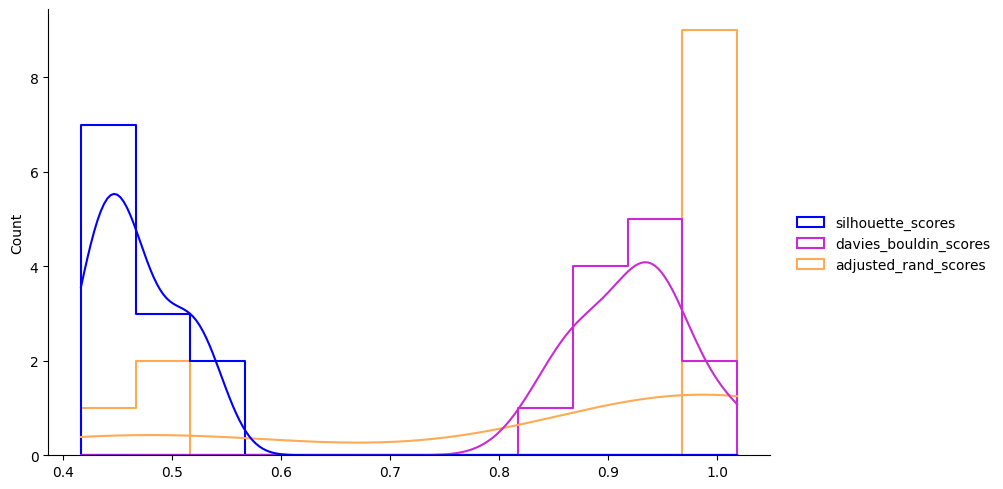

In [8]:
sns.displot(
    cluster_metrics_df[["silhouette_scores", "davies_bouldin_scores", "adjusted_rand_scores"]],
    # cluster_metrics_df[["months_from_start", "silhouette_scores", "davies_bouldin_scores", "adjusted_rand_scores"]],
    # x="months_from_start",
    bins=cluster_metrics_df.shape[0],
    kde=True,
    element="step",
    lw=1.5,
    aspect=1.6,
    alpha=0.0,
    palette="gnuplot2",
)

plt.show()